In [1]:
import os
import random
import torch

import numpy as np

import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

from skimage import io
from skimage import transform

from sklearn.manifold import TSNE

from torch import nn
from torch import flatten, exp, log, sigmoid
from torch.nn import functional as F

from torch.distributions import Normal
from torch import optim
from torch.utils.data import Dataset, DataLoader

import torchvision.utils as vutils
import torchvision

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Loading PneumoniaMNIST
pneu_file_path = "/content/drive/MyDrive/PRNN/pneumoniamnist.npz"

pneu_data = np.load(pneu_file_path)
# print(pneu_data)
# Extrating training data
pneu_train_data = pneu_data["train_images"]
pneu_train_labels = pneu_data["train_labels"]

# Extracting test data
pneu_test_data = pneu_data["test_images"]

pneu_test_labels = pneu_data["test_labels"]

# Extracting validation data
pneu_val_data = pneu_data["val_images"]
pneu_val_labels = pneu_data["val_labels"]

# Vectorizing data
vector_size = pneu_train_data.shape[1] * pneu_train_data.shape[2]

pneu_train_vdata = np.resize(pneu_train_data, (pneu_train_data.shape[0],vector_size))

pneu_test_vdata = np.resize(pneu_test_data, (pneu_test_data.shape[0],vector_size))

pneu_val_vdata = np.resize(pneu_val_data, (pneu_val_data.shape[0],vector_size))

print(pneu_train_vdata.shape)
print(pneu_test_vdata.shape)
print(pneu_val_vdata.shape)

(4708, 784)
(624, 784)
(524, 784)


In [4]:
# Loading BloodMNIST
blood_file_path = "/content/drive/MyDrive/PRNN/bloodmnist.npz"

blood_data = np.load(blood_file_path)

# Extrating training data
blood_train_data = blood_data["train_images"]
blood_train_labels = blood_data["train_labels"]

# Extracting test data
blood_test_data = blood_data["test_images"]
blood_test_labels = blood_data["test_labels"]

# Extracting validation data
blood_val_data = blood_data["val_images"]
blood_val_labels = blood_data["val_labels"]

# Vectorizing data
vector_size = blood_train_data.shape[1] * blood_train_data.shape[2]

blood_train_vdata = np.resize(blood_train_data, (blood_train_data.shape[0],vector_size))

blood_test_vdata = np.resize(blood_test_data, (blood_test_data.shape[0],vector_size))

blood_val_vdata = np.resize(blood_val_data, (blood_val_data.shape[0],vector_size))

print(blood_train_vdata.shape)
print(blood_test_vdata.shape)
print(blood_val_vdata.shape)

(11959, 784)
(3421, 784)
(1712, 784)


In [5]:
# Loading Traffic signs data for bounding box regression problem
traffic_images_path = "/content/drive/MyDrive/PRNN/Traffic sign/images"
traffic_annotations_path = "/content/drive/MyDrive/PRNN/Traffic sign/annotations"

traffic_labels = list()

for annot_path in os.listdir(traffic_annotations_path):
  traffic_labels.append(annot_path)

# Ratio for test data
train_prob = 0.7

traffic_train_data = list()
traffic_test_data = list()
traffic_train_gray_data = list()
traffic_test_gray_data = list()

traffic_train_labels = list()
traffic_test_labels = list()

for i in range(len(traffic_labels)):
  tree = ET.parse(os.path.join(traffic_annotations_path, traffic_labels[i]))
  root = tree.getroot()
  
  img_file = root[1].text

  obj = root.find("object")
  bndbox = obj.find("bndbox")

  if bndbox:
    box = np.array([[int(bndbox[0].text), int(bndbox[1].text), int(bndbox[2].text), int(bndbox[3].text)]])

    img = io.imread(os.path.join(traffic_images_path, img_file))[:,:,:3]
    img_gray = io.imread(os.path.join(traffic_images_path, img_file), as_gray = True)

    if img.shape[0] == 400 and img.shape[1] == 300:
      img = transform.resize(img, (200,150), anti_aliasing = True)
      img_gray = transform.resize(img_gray, (200,150), anti_aliasing = True)

      label = box//2

      if random.random() <= train_prob:
        traffic_train_data.append(img)
        traffic_train_gray_data.append(img_gray)
        traffic_train_labels.append(label)
      else:
        traffic_test_data.append(img)
        traffic_test_gray_data.append(img_gray)
        traffic_test_labels.append(label)

In [6]:
traffic_train_labels = np.array(traffic_train_labels)
traffic_test_labels = np.array(traffic_test_labels)
print(traffic_train_labels.shape)
print(traffic_test_labels.shape)

traffic_train_data = np.array(traffic_train_data)
traffic_test_data = np.array(traffic_test_data)
traffic_train_gray_data = np.array(traffic_train_gray_data)
traffic_test_gray_data = np.array(traffic_test_gray_data)

print(traffic_train_data.shape)
print(traffic_test_data.shape)
print(traffic_test_gray_data.shape)
print(traffic_train_gray_data.shape)

traffic_train_vdata = np.resize(traffic_train_data, (traffic_train_data.shape[0],400*300*3))
traffic_test_vdata = np.resize(traffic_test_data, (traffic_test_data.shape[0],400*300*3))
traffic_train_gray_vdata = np.resize(traffic_train_gray_data, (traffic_train_gray_data.shape[0],400*300))
traffic_test_gray_vdata = np.resize(traffic_test_gray_data, (traffic_test_gray_data.shape[0],400*300))

print()
print(traffic_train_vdata.shape)
print(traffic_test_vdata.shape)
print(traffic_test_gray_vdata.shape)
print(traffic_train_gray_vdata.shape)

(511, 1, 4)
(220, 1, 4)
(511, 200, 150, 3)
(220, 200, 150, 3)
(220, 200, 150)
(511, 200, 150)

(511, 360000)
(220, 360000)
(220, 120000)
(511, 120000)


#Tiny Image Dataset Preprocessing

In [7]:
tiny_labels_file = open("/content/drive/MyDrive/PRNN/tiny-imagenet-200/words.txt")

labels_data = tiny_labels_file.read()
labels_data = labels_data.split("\n")

class_labels = dict()

for i in labels_data:
  key, val = i.split("\t")

  class_labels[key] = val

tiny_train_images = dict()

for label in class_labels:
  pass

#Data Preprocessing for pytorch

In [8]:
from ctypes import sizeof
class PneumoniaDataset(Dataset):
  def __init__(self, data, labels, num_classes, channels, size = (28,28)):
    self.data = data
    self.labels = labels
    self.classes = num_classes
    self.channels = channels

    self.size = size

  def __getitem__(self, index):
    data = transform.resize(self.data[index], self.size, anti_aliasing=True)
    
    a = None

    if self.channels != 3:
      a = np.array([data])
    else:
      a = np.array([data[:,:,0],data[:,:,1],data[:,:,2]])

    label = np.zeros((self.classes))
    label[self.labels[index]] = 1

    return torch.from_numpy(a).type(torch.FloatTensor), label

  def __len__(self):
    return self.data.shape[0]

In [9]:
pneu_pytorch_train = PneumoniaDataset(pneu_train_data, pneu_train_labels, 2, 1, (28,28))
pneu_pytorch_test = PneumoniaDataset(pneu_test_data, pneu_test_labels, 2, 1)
pneu_pytorch_val = PneumoniaDataset(pneu_val_data, pneu_val_labels, 2, 1)
#for i in range(4000):
#  print(pneu_pytorch_train[i][0].shape,pneu_train_labels[i])
pneu_train_loader = DataLoader(pneu_pytorch_train, batch_size=214, shuffle=True, num_workers=2)
pneu_test_loader = DataLoader(pneu_pytorch_test, batch_size=214, shuffle=True, num_workers=2)
pneu_val_loader = DataLoader(pneu_pytorch_val, batch_size=214, shuffle=True, num_workers=2)

In [10]:
blood_pytorch_train = PneumoniaDataset(blood_train_data, blood_train_labels, 8, 3)
blood_pytorch_test = PneumoniaDataset(blood_test_data, blood_test_labels, 8, 3)
blood_pytorch_val = PneumoniaDataset(blood_val_data, blood_val_labels, 8, 3)
#for i in range(4000):
#  print(blood_pytorch_train[i][0].shape,blood_train_labels[i])
blood_train_loader = DataLoader(blood_pytorch_train, batch_size=214, shuffle=True, num_workers=2)
blood_test_loader = DataLoader(blood_pytorch_test, batch_size=214, shuffle=True, num_workers=2)
blood_val_loader = DataLoader(blood_pytorch_val, batch_size=214, shuffle=True, num_workers=2)

In [11]:
pneu1_pytorch_train = PneumoniaDataset(pneu_train_data, pneu_train_labels, 2, 1, (64,64))
pneu1_pytorch_test = PneumoniaDataset(pneu_test_data, pneu_test_labels, 2, 1, (64,64))
pneu1_pytorch_val = PneumoniaDataset(pneu_val_data, pneu_val_labels, 2, 1, (64,64))
#for i in range(4000):
#  print(pneu_pytorch_train[i][0].shape,pneu_train_labels[i])
pneu1_train_loader = DataLoader(pneu1_pytorch_train, batch_size=214, shuffle=True, num_workers=2)
pneu1_test_loader = DataLoader(pneu1_pytorch_test, batch_size=214, shuffle=True, num_workers=2)
pneu1_val_loader = DataLoader(pneu1_pytorch_val, batch_size=214, shuffle=True, num_workers=2)

In [12]:
class tinyImageGAN(Dataset):
  def __init__(self):
    self.path = "/content/drive/MyDrive/PRNN/tiny-imagenet-200/train/n01443537/images"
    self.image_paths = os.listdir(self.path)

  def __getitem__(self,index):
    img = io.imread(os.path.join(self.path,self.image_paths[index]))
    img = np.array([img[:,:,0],img[:,:,1],img[:,:,2]])

    return torch.from_numpy(img).type(torch.FloatTensor), 0

  def __len__(self):
    return len(self.image_paths)

In [13]:
tiny_pytorch_train = tinyImageGAN()
tiny_loader = DataLoader(tiny_pytorch_train, shuffle = True, num_workers = 2)

#DCGAN

In [14]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
device

device(type='cpu')

In [15]:
def genrandom_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [16]:
class Generator(nn.Module):
    def __init__(self, z_len, channels, outsize):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d( z_len, outsize * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(outsize * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(outsize * 8, outsize * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(outsize * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( outsize * 4, outsize * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(outsize * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( outsize * 2, outsize, 4, 2, 1, bias=False),
            nn.BatchNorm2d(outsize),
            nn.ReLU(True),
            nn.ConvTranspose2d( outsize, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.gen(input)

class Discriminator(nn.Module):
    def __init__(self, channels, feat_size):
        super(Discriminator, self).__init__()
        self.dis = nn.Sequential(
            nn.Conv2d(channels, feat_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feat_size, feat_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feat_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feat_size * 2, feat_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feat_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feat_size * 4, feat_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feat_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feat_size * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.dis(input)

In [17]:
z_len = 100
channels = 1
outsize = 64

generator = Generator(z_len, channels, outsize).to(device)
discriminator = Discriminator(channels, outsize).to(device)

generator.apply(genrandom_weights)
discriminator.apply(genrandom_weights)

Discriminator(
  (dis): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [18]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, z_len, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerG = optim.Adam(generator.parameters(), lr=0.0005, betas=(0.5, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=0.0005, betas=(0.5, 0.999))

In [19]:
#Training part
img_list = list()
G_losses = list()
D_losses = list()

epochs = 5
iters = 0
for epoch in range(epochs):
    for i, data in enumerate(pneu1_train_loader, 0):
        generator.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        output = discriminator(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, z_len, 1, 1, device=device)
        fake = generator(noise)
        label.fill_(fake_label)
        output = discriminator(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        generator.zero_grad()
        label.fill_(real_label)
        output = discriminator(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epochs, i, len(pneu1_train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(pneu1_train_loader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

[0/5][0/22]	Loss_D: 1.4206	Loss_G: 11.8253	D(x): 0.6877	D(G(z)): 0.5477 / 0.0000
[1/5][0/22]	Loss_D: 1.6369	Loss_G: 0.0498	D(x): 0.9310	D(G(z)): 0.7663 / 0.9524
[2/5][0/22]	Loss_D: 26.3271	Loss_G: 0.0933	D(x): 0.0003	D(G(z)): 1.0000 / 0.9367
[3/5][0/22]	Loss_D: 13.0237	Loss_G: 0.1059	D(x): 0.0643	D(G(z)): 0.9865 / 0.9025
[4/5][0/22]	Loss_D: 8.5147	Loss_G: 0.2548	D(x): 0.2843	D(G(z)): 0.9720 / 0.8094


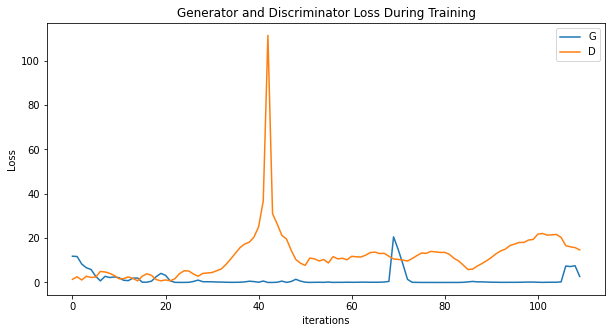

In [20]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

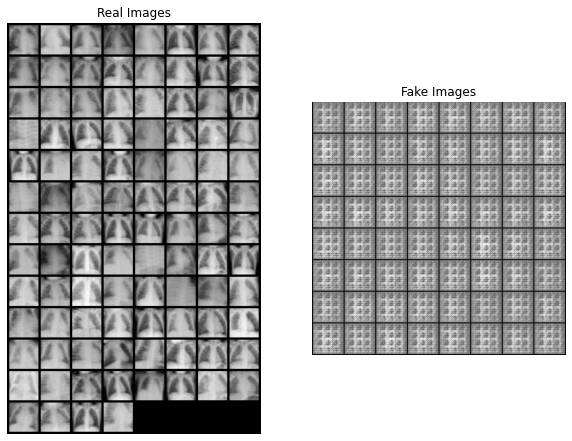

In [21]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(pneu1_train_loader))

# Plot the real images
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:100], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

#VAE

In [22]:
# Encoder
class VAE_Encoder(nn.Module):
  def __init__(self, dims, device):
    super(VAE_Encoder, self).__init__()
    self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
    self.batch2 = nn.BatchNorm2d(16)
    self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
    self.Linear1 = nn.Linear(288, 128)
    self.Linear2 = nn.Linear(128, dims)
    self.Linear3 = nn.Linear(128, dims)

    # Using Guassian with 0 mean and identity variance
    self.distribution = Normal(0,1)
    #self.distribution.loc = self.distribution.loc.cuda()
    #self.distribution.scale = self.distribution.scale.cuda()
    self.c = 0

    self.dev = device

  def forward(self, x):
    x = x.to(self.dev)
    x = F.relu(self.conv1(x))
    x = F.relu(self.batch2(self.conv2(x)))
    x = F.relu(self.conv3(x))
    x = flatten(x, start_dim = 1)
    x = F.relu(self.Linear1(x))
    mean = self.Linear2(x)
    var = exp(self.Linear3(x))
    z = mean + self.distribution.sample(mean.shape)*var
    self.c = (var**2 + mean**2 - log(var) - 1/2).sum()
    return z

# Decoder
class VAE_Decoder(nn.Module):
    def __init__(self, dims):
        super(VAE_Decoder, self).__init__()
        self.linear = nn.Sequential(
                                    nn.Linear(dims, 128),
                                    nn.ReLU(True),
                                    nn.Linear(128, 3 * 3 * 32),
                                    nn.ReLU(True)
                                  )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.convs = nn.Sequential(
                                    nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
                                    nn.BatchNorm2d(16),
                                    nn.ReLU(True),
                                    nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
                                    nn.BatchNorm2d(8),
                                    nn.ReLU(True),
                                    nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
                                  )
        
    def forward(self, x):
        x = self.linear(x)
        x = self.unflatten(x)
        x = self.convs(x)
        x = sigmoid(x)
        return x

# Merging encoder and decoder
class VAE(nn.Module):
    def __init__(self, dims, device):
        super(VAE, self).__init__()
        self.encoder = VAE_Encoder(dims, device)
        self.decoder = VAE_Decoder(dims)
        self.dev = device

    def forward(self, x):
        x = x.to(self.dev)
        z = self.encoder(x)
        return self.decoder(z)


In [23]:
vae = VAE(4,device)

optimizer = optim.Adam(vae.parameters())

In [24]:
def train_epoch(vae, device, dataloader, optimizer):
    vae.train()
    train_loss = 0.0
    for x, _ in dataloader: 
        x = x.to(device)
        x_hat = vae(x)
        loss = ((x - x_hat)**2).sum() + vae.encoder.c

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [25]:
def test_epoch(vae, device, dataloader):
    vae.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)

            encoded_data = vae.encoder(x)

            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.c
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [26]:
num_epochs = 50

for epoch in range(num_epochs):
   train_loss = train_epoch(vae,device,pneu_train_loader,optimizer)
   val_loss = test_epoch(vae,device,pneu_test_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))

	 partial train loss (single batch): 8263.003906
	 partial train loss (single batch): 7691.129395
	 partial train loss (single batch): 7419.587402
	 partial train loss (single batch): 7286.725586
	 partial train loss (single batch): 6684.535645
	 partial train loss (single batch): 6535.081055
	 partial train loss (single batch): 6561.126465
	 partial train loss (single batch): 6095.144043
	 partial train loss (single batch): 6123.422363
	 partial train loss (single batch): 6008.135254
	 partial train loss (single batch): 6059.076172
	 partial train loss (single batch): 5740.663086
	 partial train loss (single batch): 5692.161133
	 partial train loss (single batch): 5672.904297
	 partial train loss (single batch): 5559.481445
	 partial train loss (single batch): 5549.035156
	 partial train loss (single batch): 5648.487305
	 partial train loss (single batch): 5186.417480
	 partial train loss (single batch): 5049.975098
	 partial train loss (single batch): 4991.239258
	 partial train loss

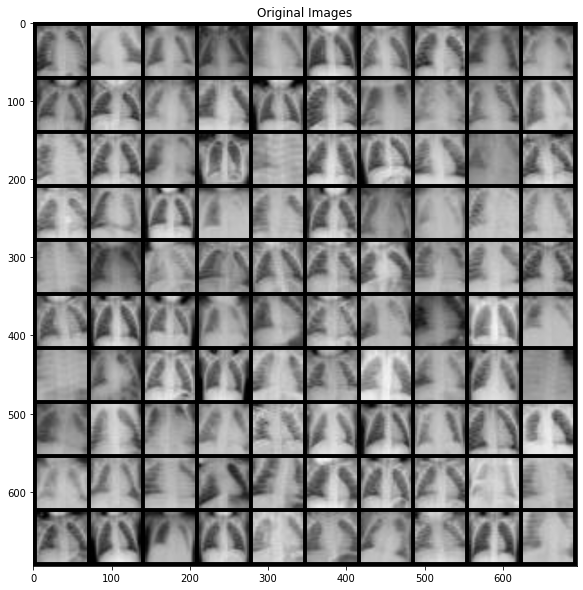

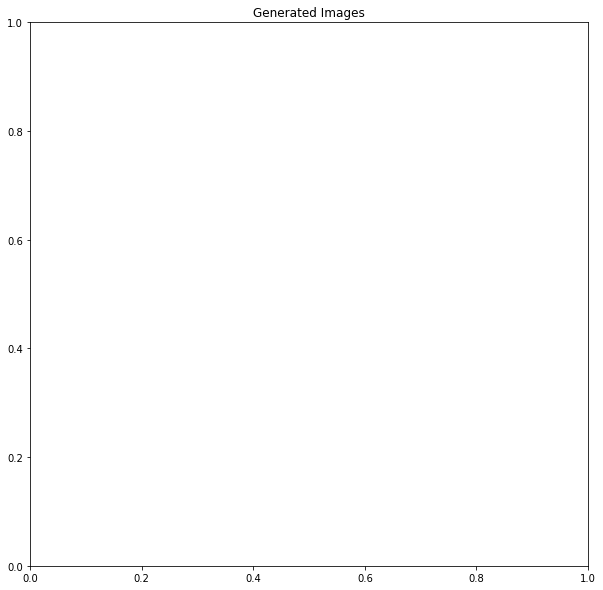

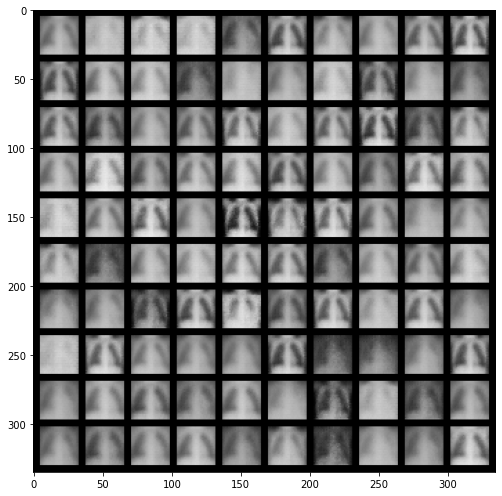

In [27]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

vae.eval()

with torch.no_grad():
    latent = torch.randn(214, 4, device=device)

    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    plt.figure(figsize=(10,10))
    plt.title("Original Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:100], 10,5).cpu(),(1,2,0)))
    plt.show()

    plt.figure(figsize=(10,10))
    plt.title("Generated Images")
    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

#t-SNE

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


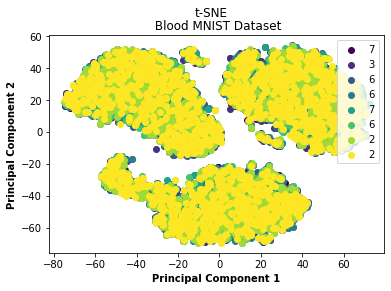

In [28]:
X = blood_train_vdata
y = np.ravel(blood_train_labels)

tsne=TSNE(2)
X_trans=tsne.fit_transform(X)
x1 = X_trans[:, 0]
x2 = X_trans[:, 1]
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]
class_distr = []

for i, l in enumerate(np.unique(y)):
    _x1 = x1[y == l]
    _x2 = x2[y == l]
    _y = y[y == l]
    class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))

plt.legend(class_distr, y, loc=1)

plt.suptitle("t-SNE")
plt.title(" Blood MNIST Dataset")
plt.xlabel('Principal Component 1',fontweight ='bold')
plt.ylabel('Principal Component 2',fontweight ='bold')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


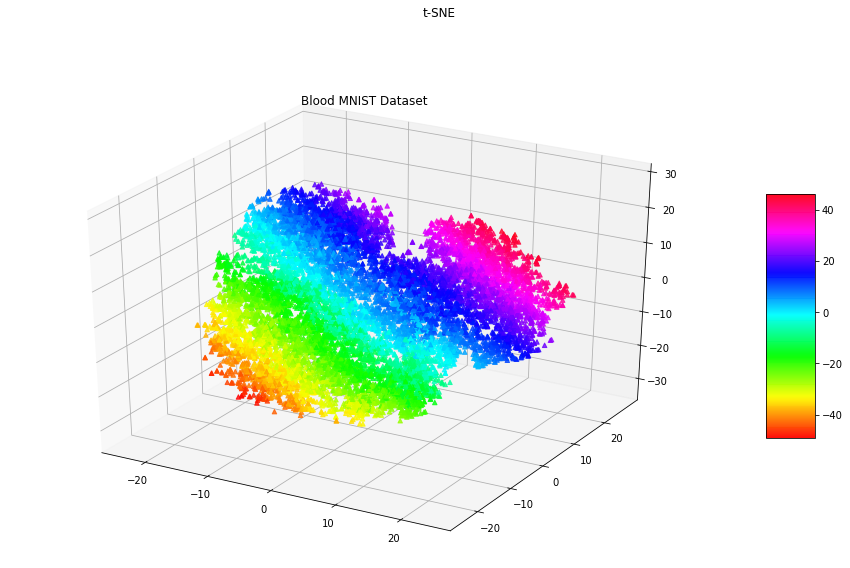

In [29]:
from mpl_toolkits.mplot3d import Axes3D
X = blood_train_vdata
y = np.ravel(blood_train_labels)

tsne=TSNE(3)
X_trans = tsne.fit_transform(X)
x1 = X_trans[:, 0]
x2 = X_trans[:, 1]
x3 = X_trans[:, 2]  
my_cmap = plt.get_cmap('hsv')
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
sctt = ax.scatter3D(x1, x2, x3,
                    alpha = 0.8,
                    c = (x1 + x2 + x3),
                    cmap = my_cmap,
                    marker ='^') 
plt.suptitle("t-SNE")
plt.title("Blood MNIST Dataset")
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5,) 

plt.show()

# PRINCIPAL COMPONENT ANALYSIS

In [30]:
class PCA():
    def __init__(self,dim):
        self.dim=dim
        self.covariance_matrix=None
    def calculate_covariance_matrix(self,X,Y=None):
        if Y is None:
            Y = X
        n_samples = np.shape(X)[0]
        self.covariance_matrix = np.array((1 / (n_samples-1)) * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0)),dtype=float)
    def transform(self, X):
        eigenvalues, eigenvectors = np.linalg.eig(self.covariance_matrix
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx][:self.dim]
        eigenvectors = np.atleast_1d(eigenvectors[:, idx])[:, :self.dim]
        X_transformed = X.dot(eigenvectors)
        return X_transformed

SyntaxError: ignored

projecting Blood MNIST dataset on 2 dimensions

In [ ]:
X = blood_train_vdata
y = np.ravel(blood_train_labels)
pca=PCA(2)
pca.calculate_covariance_matrix(X)
X_trans=pca.transform(X)
x1 = X_trans[:, 0]
x2 = X_trans[:, 1]
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]
class_distr = []

for i, l in enumerate(np.unique(y)):
    _x1 = x1[y == l]
    _x2 = x2[y == l]
    _y = y[y == l]
    class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))
plt.legend(class_distr, y, loc=1)
plt.suptitle("PCA Dimensionality Reduction")
plt.title(" Blood MNIST Dataset")
plt.xlabel('Principal Component 1',fontweight ='bold')
plt.ylabel('Principal Component 2',fontweight ='bold')
plt.show()



projecting Blood MNIST dataset on 3 dimensions

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
X = blood_train_vdata
y = np.ravel(blood_train_labels)
pca=PCA(3)
pca.calculate_covariance_matrix(X)
X_trans=pca.transform(X)
x1 = X_trans[:, 0]
x2 = X_trans[:, 1]
x3 = X_trans[:, 2]  
my_cmap = plt.get_cmap('hsv')
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
sctt = ax.scatter3D(x1, x2, x3,
                    alpha = 0.8,
                    c = (x1 + x2 + x3),
                    cmap = my_cmap,
                    marker ='^') 
plt.title("Blood MNIST Dataset")
ax.set_xlabel('Principal Component 1', fontweight ='bold')
ax.set_ylabel('Principal Component 2', fontweight ='bold')
ax.set_zlabel('Principal Component 3', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5,) 
plt.show()

